Check for the required packages

In [1]:
%%bash

pip list > installed_packages

check_package() {
    if grep -q $1 installed_packages; then
        echo Package $1 is installed
    else
        echo installing $1
        pip install $1
    fi
}

check_package "pandas"
check_package "matplotlib"
check_package "seaborn"
check_package "ipywidgets"

Package pandas is installed
Package matplotlib is installed
Package seaborn is installed
Package ipywidgets is installed


Check out the repository

In [2]:
%%bash 

if [[ -d covid-19 ]]; then
    cd covid-19
    git pull
    cd ..
else
    git clone https://github.com/datasets/covid-19
fi

ls -lt covid-19

Updating ac9187d..94a0fdd
Fast-forward
 data/countries-aggregated.csv          |   583 +-
 data/key-countries-pivoted.csv         |    23 +-
 data/time-series-19-covid-combined.csv |  3098 +-
 data/us_confirmed.csv                  | 66340 +++++++++++++++++-------------
 data/us_deaths.csv                     | 66416 ++++++++++++++++++-------------
 data/worldwide-aggregated.csv          |    23 +-
 datapackage.json                       |    30 +-
 7 files changed, 78719 insertions(+), 57794 deletions(-)
total 48
-rw-r--r--  1 syad  staff  15844 Apr 27 20:01 datapackage.json
drwxr-xr-x  9 syad  staff    288 Apr 27 20:01 data
drwxr-xr-x  4 syad  staff    128 Apr 23 20:20 scripts
-rw-r--r--  1 syad  staff   4612 Apr 23 20:20 README.md


From https://github.com/datasets/covid-19
   ac9187d..94a0fdd  master     -> origin/master


And the packages we're going to use for the visualization

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Read the aggregated data of all countires

In [4]:
df = pd.read_csv("./covid-19/data/countries-aggregated.csv")

In [5]:
df.columns

Index(['Date', 'Country', 'Confirmed', 'Recovered', 'Deaths'], dtype='object')

Lower the cases of all the columns to make it easier to work with names

In [6]:
df.columns = map(str.lower, df.columns)

In [7]:
df

,date,country,confirmed,recovered,deaths
0,2020-01-22,Afghanistan,0,0,0
1,2020-01-22,Albania,0,0,0
2,2020-01-22,Algeria,0,0,0
3,2020-01-22,Andorra,0,0,0
4,2020-01-22,Angola,0,0,0
...,...,...,...,...,...
17755,2020-04-26,West Bank and Gaza,342,83,2
17756,2020-04-26,Western Sahara,6,5,0
17757,2020-04-26,Yemen,1,1,0
17758,2020-04-26,Zambia,88,42,3


In [8]:
df[df['country'] == 'Afghanistan']

,date,country,confirmed,recovered,deaths
0,2020-01-22,Afghanistan,0,0,0
185,2020-01-23,Afghanistan,0,0,0
370,2020-01-24,Afghanistan,0,0,0
555,2020-01-25,Afghanistan,0,0,0
740,2020-01-26,Afghanistan,0,0,0
...,...,...,...,...,...
16835,2020-04-22,Afghanistan,1176,166,40
17020,2020-04-23,Afghanistan,1279,179,42
17205,2020-04-24,Afghanistan,1351,188,43
17390,2020-04-25,Afghanistan,1463,188,47


Clean up the names and make a list of all the countries

In [9]:
# punctuations = [',', ' ', '-', '_']
# punctuation_p = lambda s: s in punctuations
# remove_punctuations = lambda s: ''.join([_ for _ in s if not punctuation_p(_)])

    
# country_names = [remove_punctuations(name) for name in list(set(df['country']))]

country_names = [name for name in list(set(df['country']))]


Create a separate dataframe for each country

In [10]:
dfs = {country: df[df['country'] == country] for country in country_names}

In [11]:
dfs = {country: dfs[country] for country in dfs if len(dfs[country]) > 0}

We're going to need the new cases for each day (call it `new_cases`). The `pd.option` is a workaround so we don't get the warning message

In [13]:
# https://stackoverflow.com/questions/21463589/pandas-chained-assignments
pd.options.mode.chained_assignment = None

def add_new_cases(df):
    df.loc[:, 'new_cases'] = df['confirmed'].diff().fillna(0, downcast='infer')
    return df

def add_new_deaths(df):
    df.loc[:, 'new_deaths'] = df['deaths'].diff().fillna(0, downcast='infer')
    return df

In [14]:
add_new_deaths(add_new_cases(dfs['Germany']))

,date,country,confirmed,recovered,deaths,new_cases,new_deaths
65,2020-01-22,Germany,0,0,0,0,0
250,2020-01-23,Germany,0,0,0,0,0
435,2020-01-24,Germany,0,0,0,0,0
620,2020-01-25,Germany,0,0,0,0,0
805,2020-01-26,Germany,0,0,0,0,0
...,...,...,...,...,...,...,...
16900,2020-04-22,Germany,150648,99400,5279,2357,246
17085,2020-04-23,Germany,153129,103300,5575,2481,296
17270,2020-04-24,Germany,154999,109800,5760,1870,185
17455,2020-04-25,Germany,156513,109800,5877,1514,117


In [15]:
dfs = {country: add_new_deaths(add_new_cases(dfs[country])) for country in country_names}

We only consider countries at the top of the list to declutter the plot area. You can change the threshold or ignore it.

In [16]:
max_cases = 20000

countries_large = [country_name for country_name in country_names if dfs[country_name]['confirmed'].iloc[-1] > max_cases]

In [17]:
countries_large

['US',
 'Belgium',
 'Iran',
 'Netherlands',
 'Canada',
 'India',
 'Ecuador',
 'Italy',
 'United Kingdom',
 'Switzerland',
 'Spain',
 'Brazil',
 'Turkey',
 'Portugal',
 'France',
 'Russia',
 'Peru',
 'China',
 'Germany']

Before putting it all together create a little prototype of plots we want to create

In [18]:
de = dfs['Germany']
de

,date,country,confirmed,recovered,deaths,new_cases,new_deaths
65,2020-01-22,Germany,0,0,0,0,0
250,2020-01-23,Germany,0,0,0,0,0
435,2020-01-24,Germany,0,0,0,0,0
620,2020-01-25,Germany,0,0,0,0,0
805,2020-01-26,Germany,0,0,0,0,0
...,...,...,...,...,...,...,...
16900,2020-04-22,Germany,150648,99400,5279,2357,246
17085,2020-04-23,Germany,153129,103300,5575,2481,296
17270,2020-04-24,Germany,154999,109800,5760,1870,185
17455,2020-04-25,Germany,156513,109800,5877,1514,117


In [19]:
moving_average = lambda df, n: df.rolling(n).mean().fillna(0).map(np.floor).map(int)

In [20]:
import datetime
import matplotlib.dates as mdates

def f(slider):

    today = datetime.date.today()
    x = np.arange(1, 10, 0.1)
    x_date = [today - datetime.timedelta(i) for i in range(len(x))]
    y = np.exp(x)

    fmt = mdates.DateFormatter('%b')
    locator = mdates.MonthLocator()
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(x_date, y)
    ax.xaxis.set_major_formatter(fmt)
    ax.xaxis.set_major_locator(locator)

from ipywidgets import widgets
import datetime
dates = [datetime.date(2015, i, 1) for i in range(1, 13)]
# options = [(i.strftime('%b'), i) for i in dates]
options = [(i.strftime('%b'), i) for i in x_date]


widgets.interactive(f, slider=widgets.SelectionRangeSlider(
    options=options,
    index=(0, 3),
    description='Months',
    disabled=False,
    continuous_update=False))

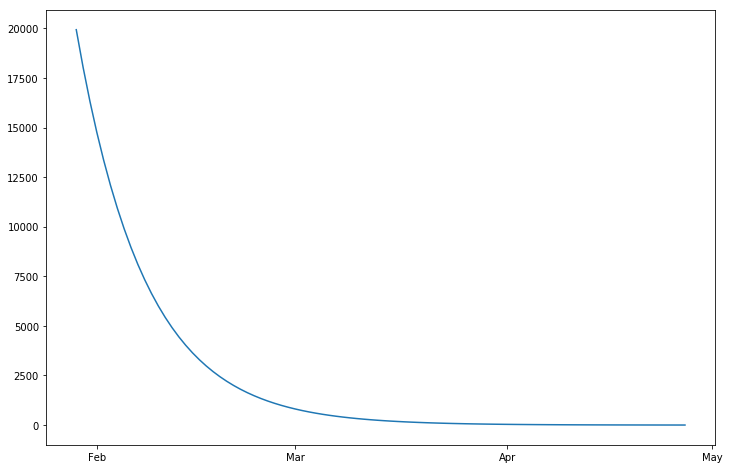

In [22]:
today = datetime.date.today()
x = np.arange(1, 10, 0.1)
x_date = [today - datetime.timedelta(i) for i in range(len(x))]
y = np.exp(x)

# https://matplotlib.org/3.1.1/api/dates_api.html#matplotlib.dates.ConciseDateFormatter
fmt = mdates.DateFormatter('%b')
locator = mdates.MonthLocator()
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_date, y)
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_major_locator(locator)

from ipywidgets import widgets
import datetime
dates = [datetime.date(2015, i, 1) for i in range(1, 13)]
# options = [(i.strftime('%b'), i) for i in dates]
options = [(i.strftime('%b'), i) for i in x_date]

out = widgets.SelectionRangeSlider(
    options=options,
    index=(0, 4),
    description='Months',
    disabled=False,
    continuous_update=False
)


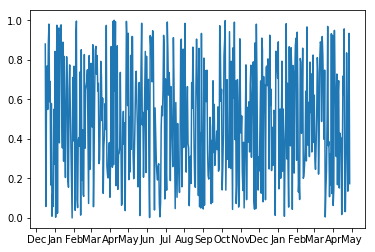

In [23]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Generate some random date-time data
numdays = 500
base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(0, numdays)]
y = np.random.rand(numdays)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')


plt.plot(date_list,y)
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.show()

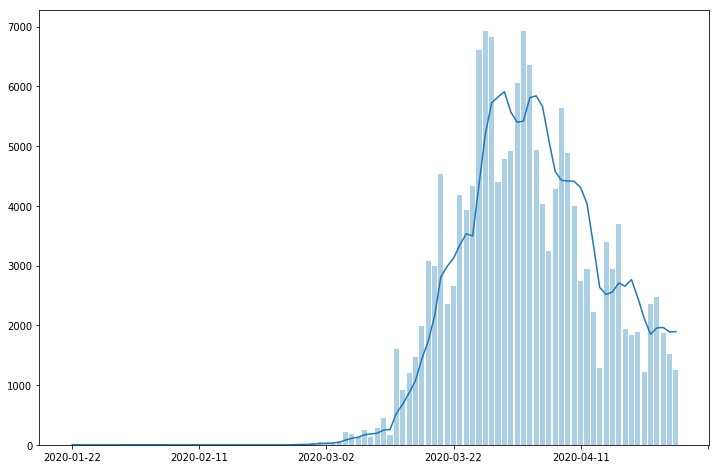

In [24]:
cl = [sns.color_palette("Blues_r", 5)[3]] * len(de)
cl0 = sns.color_palette("Blues_r", 5)[3]

de = dfs['Germany']

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(de['date'], de['new_cases'], fc=cl0)
ax.plot(de['date'], moving_average(de['new_cases'], 5))
ax.xaxis.set_major_locator(plt.MaxNLocator(7))


I didn't put a check for `ipywidgets` package. You can find the installation instructions in the following [page](https://ipywidgets.readthedocs.io/en/latest/user_install.html:link)

In [29]:
from ipywidgets import interactive

def draw_new_cases(name, **kwargs):
    
    log_scale = kwargs.get('log_scale', False)
    ylimit_on_focus = kwargs.get('Y_limit', False)
    has_moving_ave = kwargs.get('has_moving_ave', False)
    days_moving_ave = kwargs.get('days_moving_ave', 5)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    pltargs = {'color':'b', 'lw':0.15}
    for country in countries_large:
        if name == country: continue
        df = dfs[country]
        ax.plot(df['date'], df['new_cases'], **pltargs)
        
    # now the highlighted plot
    pltargs = {'color':'b', 'lw':2}
    df = dfs[name]
    ax.bar(df['date'], df['new_cases'], color=cl)
    if has_moving_ave:
        ax.plot(df['date'], moving_average(df['new_cases'], days_moving_ave), **pltargs)
        
    if log_scale: ax.set_yscale('log')
    if ylimit_on_focus: ax.set_ylim(bottom=0., top=df['new_cases'].max()*1.1)
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    
        
# interactive(draw_new_cases,
#             {'name':countries_large,
#             'log scale':False,
#             'Y-limit':True,
#            'moving average':(2, 10)})
interactive(draw_new_cases,
            name=countries_large,
             log_scale=False,
             Y_limit=True,
            has_moving_ave=True,
            days_moving_ave=(2, 10))

interactive(children=(Dropdown(description='name', options=('US', 'Belgium', 'Iran', 'Netherlands', 'Canada', …

In [30]:
from ipywidgets import Layout, Output, HBox, VBox, Label, Button
from ipywidgets import RadioButtons, IntRangeSlider, IntSlider, GridspecLayout, Checkbox, ColorPicker, Textarea, Dropdown

In [31]:
cl0

(0.6718954248366014, 0.8143790849673203, 0.9006535947712418)

In [33]:
%matplotlib widget

output = Output()
with output:
    fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 3))

fig.canvas.toolbar_position = 'bottom'    

In [34]:
for country in countries_large:
    df = dfs[country]
    ax.plot(df['date'], df['new_cases'])

In [35]:
layout_checkbox = Layout(width='50px', height='50px')
layout_list = Layout(width='90px', height='30px')

max_date = Checkbox()
mov_ave = Checkbox(layout=layout_checkbox)
log_scale = Checkbox(layout=layout_checkbox)

date_slider = IntRangeSlider()
mov_ave_slider = IntSlider(value=5, min=2, max=10)

y_lim = Checkbox(layout=Layout(width='120px', height='30px'))
color_picker = ColorPicker(layout=layout_list)
thickness = Textarea("1.2", layout=layout_list)

country_list = Dropdown(options=countries_large,
                        layout=layout_list)

In [36]:
grid = GridspecLayout(n_rows=8, n_columns=15, width='800x',
                     justify_content='flex-start', align_items='flex-start')
grid[1, 1] = country_list
grid[3, 1] = max_date
grid[5, 1] = mov_ave
grid[7, 1] = log_scale

grid[3, 2] = date_slider
grid[5, 2] = mov_ave_slider
grid[7, 2] = y_lim

grid[5, 3] = color_picker
grid[5, 4] = thickness
grid[:, 5:] = output

grid

GridspecLayout(children=(Dropdown(layout=Layout(grid_area='widget009', height='30px', width='90px'), options=(…

In [37]:
# Callbacks

def update_mov_ave(value):
    if value.new:
        mov_ave_slider.disabled = True
    else:
        mov_ave_slider.disabled = False
#        
mov_ave.observe(update_mov_ave, 'value')

def update_max_date(value):
    if value.new:
        date_slider.disabled = True
    else:
        date_slider.disabled = False
#
max_date.observe(update_max_date, 'value')
